# Εργασία 1. Επιβλεπόμενη Μάθηση: Ταξινόμηση 
## Ομάδα: 86
Σκουρτσή Δήμητρα Άννα: el18044

Στεργιόπουλος Αναστάσιος: el18605

Φιλίππα Μυρσίνη: el18151
## Μέρος 2. Kaggle Dataset

Το dataset με το οποίο εργαζόμαστε είναι το Trip Pricing with Taxi Mobility Analytics. Ο στόχος μας είναι να δημιουργήσουμε ένα μοντέλο το οποίο θα προβλέπει το pricing type της διαδρομής που θέλει να κάνει ο πελάτης, ώστε να γίνει η διαδικασία αντιστοίχησης του πελάτη με το κατάλληλο ταξί γρήγορη και αποτελεσματική.

In [ ]:
import os
import time
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [ ]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/taxi-pricing-with-mobility-analytics/sigma_cabs.csv
/kaggle/input/taxi-pricing-with-mobility-analytics/test.csv


In [ ]:
data = pd.read_csv("/kaggle/input/taxi-pricing-with-mobility-analytics/sigma_cabs.csv")
print(data)

            Trip_ID  Trip_Distance Type_of_Cab  Customer_Since_Months  \
0       T0005689460           6.77           B                    1.0   
1       T0005689461          29.47           B                   10.0   
2       T0005689464          41.58         NaN                   10.0   
3       T0005689465          61.56           C                   10.0   
4       T0005689467          54.95           C                   10.0   
...             ...            ...         ...                    ...   
131657  T0005908509          11.72           D                    1.0   
131658  T0005908510          74.81           C                    7.0   
131659  T0005908512          40.17           C                   10.0   
131660  T0005908513          46.88           B                    4.0   
131661  T0005908514          31.96           A                    7.0   

        Life_Style_Index Confidence_Life_Style_Index Destination_Type  \
0                2.42769                          

In [ ]:
mapping = {'Female': 0, 'Male': 1}
data = data.replace({"Gender": mapping})

dct = dict(zip(list(string.ascii_uppercase) , np.arange(1, 27)))
print("The mapping for the letters is:",dct,"\n")

data = data.replace({"Type_of_Cab": dct, "Confidence_Life_Style_Index": dct, "Destination_Type": dct})

The mapping for the letters is: {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26} 



In [ ]:
np_data = data.to_numpy()
labels = np_data[:,-1].astype(int)
features = np_data[:,1:-1]

print('The labels of the dataset are: ',set(labels),'\n')

(classs, counts)=np.unique(labels, return_counts=True)
frequencies = np.asarray((classs, counts)).T

per1=(frequencies[0][1]/len(labels))*100
print("Percentage of type 1 in the dataset: ",per1,"%\n")
per2=(frequencies[1][1]/len(labels))*100
print("Percentage of type 2 in the dataset: ",per2,"%\n")
per3=(frequencies[2][1]/len(labels))*100
print("Percentage of type 3 in the dataset: ",per3,"%\n")


def check_nulls(i_num, j_num, thr, show_per):
    l = []
    totalcounter=0  
    for i in range(0,i_num):
        counter=0
        for j in range(0,j_num):
            if i_num > j_num:
                if str(features[i][j]) == 'nan':
                    counter+=1
            else:
                if str(features[j][i]) == 'nan':
                    counter+=1
            if counter>0:
                 totalcounter+=1
        if counter >= thr:
            l.append(i)
    if show_per:
        print("Total empty values are", totalcounter)
        total = i_num*j_num
        per = (totalcounter/total)*100
        print("The percentage of empty values to total values is", per)
    return l

print(len(check_nulls(131662, 12, 8, 1)), "rows have more than 60% empty features")
print(len(check_nulls(12, 131662, 78996, 0)), "features have more than 60% empty rows")

The labels of the dataset are:  {1, 2, 3} 

Percentage of type 1 in the dataset:  20.66959335267579 %

Percentage of type 2 in the dataset:  43.086084063738966 %

Percentage of type 3 in the dataset:  36.244322583585245 %

Total empty values are 613657
The percentage of empty values to total values is 38.840427255649566
0 rows have more than 60% empty features
0 features have more than 60% empty rows


#### Undersampling
Το dataset μας δεν είναι ισορροπημένο (class1: 20%, class2: 43%, class3: 36%). Για να το ισορροπήσουμε θα κάνουμε undersampling, ώστε τελικά οι 3 κλάσεις να είναι ισοκατανεμημένες. Διαλέγουμε undersampling λόγω του μεγέθους του dataset.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MultiLabelBinarizer
# αρχικοποίηση του RandomOverSampler
rus = RandomUnderSampler()
features_resampled, labels_resampled = rus.fit_resample(features,labels)

# εκτυπώνουμε τις νέες διαστάσεις του train set
print(features_resampled.shape)
print(labels_resampled.shape)
print(labels_resampled)
# επιβεβαιώνουμε ότι το training set έχει εξισορροπηθεί με undersampling
unique_after, counts_after = np.unique(labels_resampled, return_counts=True)
print("After undersampling:",dict(zip(unique_after, counts_after)))

data.isnull().sum()

(81642, 12)
(81642,)
[1 1 1 ... 3 3 3]
After undersampling: {1: 27214, 2: 27214, 3: 27214}


Trip_ID                            0
Trip_Distance                      0
Type_of_Cab                    20210
Customer_Since_Months           5920
Life_Style_Index               20193
Confidence_Life_Style_Index    20193
Destination_Type                   0
Customer_Rating                    0
Cancellation_Last_1Month           0
Var1                           71030
Var2                               0
Var3                               0
Gender                             0
Surge_Pricing_Type                 0
dtype: int64

#### Split dataset

In [ ]:
pd_labels = data.iloc[:,-1]
pd_features = data.iloc[:,1:-1]
# Split our data
train, test, train_labels, test_labels = train_test_split(pd_features, pd_labels, test_size=0.30)

#### Διαχειρισμός κατηγορικών NaN 

Από τα κατηγορικά χαρακτηριστικά απουσιάζουσες τιμές έχουν μόνο τα χαρακτηριστικά "Type_of_Cab" και "Confidence_Life_Style_Index" (φαίνεται παραπάνω). Για τα χαρακτηριστικά αυτά, θέλουμε να αντικαταστήσουμε τις απουσιάζουσες τιμές τους με τη most frequent τιμή, αφού το να πάρουμε κάποια mean τιμή οπως θα κάνουμε για τα άλλα attributes δεν έχει εδώ κάποιο νόημα (δεν υπάρχει κάποιος ενδιάμεσος τύπος Taxi). Για αυτό χρησιμοποιούμε την value_counts με την επιλογή sort, η οποία μας επιστρέφει ένα Pandas Series το οποίο μετατρέπουμε σε tuple. Στο πρώτο tuple, έχουμε στο πρώτο στοιχείο το most frequent, και στο δεύτερο τον αριθμό των φορών που εμφανίζεται στο dataset. Τέλος, με χρήση της fillna, γεμίζουμε τα NaN στοιχεία με την most frequent τιμή.

In [ ]:
def fill_categorical_nan(s):
    global train, test
    count = train.loc[:, s].value_counts(sort=True)
    tuples = [tuple((x, y)) for x, y in count.items()]
    temp_train = train[s].fillna(tuples[0][0])
    temp_test = test[s].fillna(tuples[0][0])
    train = train.assign(s = temp_train)
    test = test.assign(s = temp_test)
    
fill_categorical_nan('Type_of_Cab')
fill_categorical_nan('Confidence_Life_Style_Index')

Στη συνέχεια, για τις απουσιάζουσες τιμές των υπόλοιπων χαρακτηριστικών θα χρησιμοποιήσουμε imputer  με στρατηγική mean, καθώς πρόκειται για continuous τιμές.

In [ ]:
train = train.to_numpy()
test = test.to_numpy()

imp=SimpleImputer(missing_values=np.NaN,strategy='mean')

train=imp.fit_transform(train)
test =imp.transform(test)

## Επίδοση out-of-the-box
Γνωρίζοντας πως ο στόχος της μελέτης αυτού του dataset είνα το dynamic princing, καταλαβαίνουμε πως οι λάθος εκτιμήσεις δεν είναι όσο σημαντικές όσο για κάποιο ιατρικό dataset (που κάποια λάθος ταξινόμηση μπορεί να φανεί θανάσιμη). Συνεπώς για την εκτίμηση της απόδοσης των ταξινομητών, αποφασίσαμε να χρησιμοποιήσουμε τη μετρική accuracy, καθώς είναι ο απόλυτος δείκτης.
### Dummy Classifier

In [ ]:
label_names = ["1", "2", "3"]

from sklearn.dummy import DummyClassifier
# dummy uniform
dc_uniform = DummyClassifier(strategy="uniform")
model = dc_uniform.fit(train, train_labels)
preds = dc_uniform.predict(test)
accuracy = {}
accuracy['Dummy Uniform (Random)']= accuracy_score(test_labels, preds)
f1_macro = {}
f1_macro['Dummy Uniform (Random)'] = f1_score(test_labels, preds, average='macro')
accuracy_bar = []
accuracy_bar.append(accuracy_score(test_labels, preds))
f1_macro_bar = []
f1_macro_bar.append(f1_score(test_labels, preds, average='macro'))

# dummy constant 1
dc_constant_1 = DummyClassifier(strategy="constant", constant=1)
model = dc_constant_1.fit(train, train_labels)
pred_const1 = dc_constant_1.predict(test)
accuracy['Dummy Constant 1']= accuracy_score(test_labels, pred_const1)
f1_macro['Dummy Constant 1'] = f1_score(test_labels, pred_const1, average="macro")
f1_macro_bar.append(f1_score(test_labels, pred_const1, average="macro"))
accuracy_bar.append(accuracy_score(test_labels, pred_const1))

# dummy constant 2
dc_constant_2 = DummyClassifier(strategy="constant", constant=2)
model = dc_constant_2.fit(train, train_labels)
pred_const2 = dc_constant_2.predict(test)
accuracy['Dummy Constant 2']= accuracy_score(test_labels, pred_const2)
f1_macro['Dummy Constant 2'] = f1_score(test_labels, pred_const2, average="macro")
f1_macro_bar.append(f1_score(test_labels, pred_const2, average="macro"))
accuracy_bar.append(accuracy_score(test_labels, pred_const2))

# dummy constant 3
dc_constant_3 = DummyClassifier(strategy="constant", constant=3)
model = dc_constant_3.fit(train, train_labels)
pred_const3 = dc_constant_3.predict(test)
accuracy['Dummy Constant 3']= accuracy_score(test_labels, pred_const3)
f1_macro['Dummy Constant 3'] = f1_score(test_labels, pred_const3, average="macro")
f1_macro_bar.append(f1_score(test_labels, pred_const3, average="macro"))
accuracy_bar.append(accuracy_score(test_labels, pred_const3))

# dummy most frequent
dc_most_frequent = DummyClassifier(strategy="most_frequent")
model = dc_most_frequent.fit(train, train_labels)
pred_most_freq = dc_most_frequent.predict(test)
accuracy['Dummy Most Frequent']= accuracy_score(test_labels, pred_most_freq)
f1_macro['Dummy Most Frequent'] = f1_score(test_labels, pred_most_freq, average="macro")
f1_macro_bar.append(f1_score(test_labels, pred_most_freq, average="macro"))
accuracy_bar.append(accuracy_score(test_labels, pred_most_freq))

# dummy stratified
dc_stratified = DummyClassifier(strategy="stratified")
model = dc_stratified.fit(train, train_labels)
pred_stratified = dc_stratified.predict(test)
accuracy['Dummy Stratified']= accuracy_score(test_labels, pred_stratified)
f1_macro['Dummy Stratified'] = f1_score(test_labels, pred_stratified, average="macro")
f1_macro_bar.append(f1_score(test_labels, pred_stratified, average="macro"))
accuracy_bar.append(accuracy_score(test_labels, pred_stratified))


# print result
print("Classification Accuracy on the Dataset (30% test set)\n")
sorted_accuracy = [(k, accuracy[k]) for k in sorted(accuracy, key=accuracy.get, reverse=True)]
for k, v in sorted_accuracy:
  print(k,":",v)
print("\n")

print("Classification F1 Macro on the Dataset (30% test set)\n")
sorted_f1_macro = [(k, f1_macro[k]) for k in sorted(f1_macro, key=f1_macro.get, reverse=True)]
for k, v in sorted_f1_macro:
  print(k,":",v)
print("\n")

Classification Accuracy on the Dataset (30% test set)

Dummy Constant 2 : 0.42990961796501176
Dummy Most Frequent : 0.42990961796501176
Dummy Constant 3 : 0.36281931188131344
Dummy Stratified : 0.35765462416770044
Dummy Uniform (Random) : 0.3359831894478341
Dummy Constant 1 : 0.20727107015367477


Classification F1 Macro on the Dataset (30% test set)

Dummy Stratified : 0.3320945240738784
Dummy Uniform (Random) : 0.3285979748693815
Dummy Constant 2 : 0.2004367327667611
Dummy Most Frequent : 0.2004367327667611
Dummy Constant 3 : 0.17748467397362067
Dummy Constant 1 : 0.11445707335486305




### Multi Layer Perceptron (MLP)

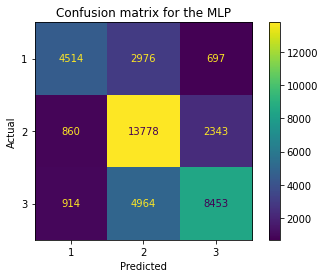

              precision    recall  f1-score   support

           1       0.72      0.55      0.62      8187
           2       0.63      0.81      0.71     16981
           3       0.74      0.59      0.65     14331

    accuracy                           0.68     39499
   macro avg       0.70      0.65      0.66     39499
weighted avg       0.69      0.68      0.67     39499



In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

mlp = MLPClassifier()
mlp.fit(train, train_labels)
pred_mlp = mlp.predict(test)

plot_confusion_matrix(mlp, test, test_labels)  
plt.title('Confusion matrix for the MLP')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, pred_mlp, target_names=label_names))
accuracy['MLP']= accuracy_score(test_labels, pred_mlp)
f1_macro['MLP'] = f1_score(test_labels, pred_mlp, average="macro")
barplotbefore = []
f1_macro_bar.append(f1_score(test_labels, pred_mlp, average="macro"))
accuracy_bar.append(accuracy_score(test_labels, pred_mlp))
barplotbefore.append(accuracy_score(test_labels, pred_mlp))

### Support Vector Machine (SVM)

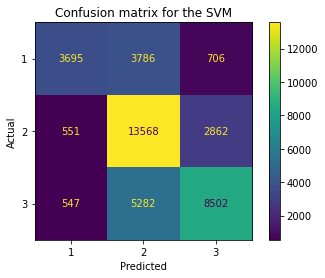

              precision    recall  f1-score   support

           1       0.77      0.45      0.57      8187
           2       0.60      0.80      0.68     16981
           3       0.70      0.59      0.64     14331

    accuracy                           0.65     39499
   macro avg       0.69      0.61      0.63     39499
weighted avg       0.67      0.65      0.65     39499



In [ ]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(train,train_labels)
pred_svm = svm.predict(test)

plot_confusion_matrix(svm, test, test_labels)  
plt.title('Confusion matrix for the SVM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show() 

print(classification_report(test_labels, pred_svm, target_names=label_names))
accuracy['SVM']= accuracy_score(test_labels, pred_svm)
f1_macro['SVM'] = f1_score(test_labels, pred_svm, average="macro")
f1_macro_bar.append(f1_score(test_labels, pred_svm, average="macro"))
accuracy_bar.append(accuracy_score(test_labels, pred_svm))
barplotbefore.append(accuracy_score(test_labels, pred_svm))

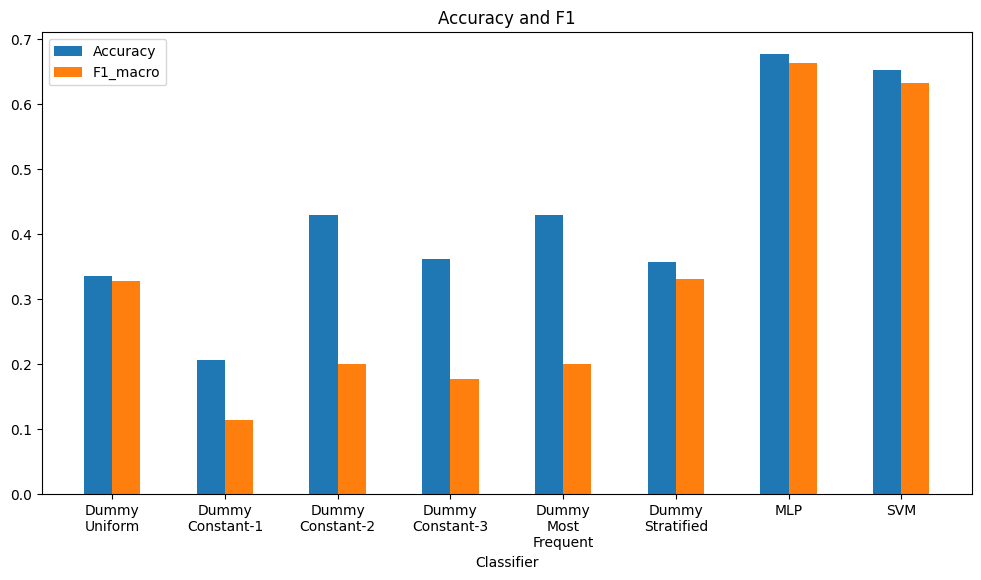

In [ ]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt;

classifiers = ['Dummy\nUniform', 'Dummy\nConstant-1', 'Dummy\nConstant-2', 'Dummy\nConstant-3', 'Dummy\nMost\nFrequent', 'Dummy\nStratified', 'MLP', 'SVM']
 
plt.figure(figsize=(12,6)) 
X_axis = np.arange(len(classifiers))
  
plt.bar(X_axis - 0.125, accuracy_bar, 0.25, label = 'Accuracy')
plt.bar(X_axis + 0.125, f1_macro_bar, 0.25, label = 'F1_macro')
  
plt.xticks(X_axis, classifiers)
plt.xlabel("Classifier")
plt.title("Accuracy and F1")
plt.legend()
plt.show()

In [ ]:
print("Classification Accuracy on the Dataset (30% test set)\n")
sorted_accuracy = [(k, accuracy[k]) for k in sorted(accuracy, key=accuracy.get, reverse=True)]
for k, v in sorted_accuracy:
  print(k,":",v)
print("\n")

print("Classification F1 Macro on the Dataset (30% test set)\n")
sorted_f1_macro = [(k, f1_macro[k]) for k in sorted(f1_macro, key=f1_macro.get, reverse=True)]
for k, v in sorted_f1_macro:
  print(k,":",v)
print("\n")

Classification Accuracy on the Dataset (30% test set)

MLP : 0.6771057495126459
SVM : 0.6522949948099952
Dummy Constant 2 : 0.42990961796501176
Dummy Most Frequent : 0.42990961796501176
Dummy Constant 3 : 0.36281931188131344
Dummy Stratified : 0.35765462416770044
Dummy Uniform (Random) : 0.3359831894478341
Dummy Constant 1 : 0.20727107015367477


Classification F1 Macro on the Dataset (30% test set)

MLP : 0.6634727001318436
SVM : 0.6327874774240682
Dummy Stratified : 0.3320945240738784
Dummy Uniform (Random) : 0.3285979748693815
Dummy Constant 2 : 0.2004367327667611
Dummy Most Frequent : 0.2004367327667611
Dummy Constant 3 : 0.17748467397362067
Dummy Constant 1 : 0.11445707335486305




Από τους dummy classifiers χειρότερη επίδοση φαίνεται να έχουν οι constant (συμπεριλαμβανμένου και του most frequent), το οποίο ήταν αναμενόμενο λόγω των πολλαπλών κλάσεων. 

Γενικότερα, όλοι οι dummy classifiers έχουν χαμηλότερη απόδοση από τους MLP και SVM και τελικά την μεγαλύτερη ακρίβεια παρουσιάζει ο ταξινομητής MLP.

Παρακάτω, θα προσπαθήσουμε να επιτύχουμε ακόμα καλύτερα αποτελέσματα για τους MLP και SVM με προεπεξεργασία των δεδομένων και βελτιστοποίηση των υπερπαραμέτρων των παραπάνω ταξινομητών.

### Βελτιστοποίηση

Οι απουσιάζουσες τιμές των χαρακτηριστικών δεν υπάρχουν πια, καθώς τις διαχειριστήκαμε παραπάνω για να μπορέσουμε να εφαρμόσουμε τους ταξινομητές.

Αντίστοιχα, τα κατηγορικά χαρακτηριστικά τα έχουμε αντικαταστήσει με αριθμητικά, επομένως δεν απαιτείται κάποια παραπάνω τροποποίηση πάνω σε αυτό.

Για την επιλογή χαρακτηριστικών, θέλουμε να "διώξουμε" αυτά που έχουν πολύ μικρή διακύμανση. Για το σκοπό αυτό ορίζουμε ένα κατώφλι (threshold), με το οποίο θα φιλτράρουμε ουσιαστικά τα δεδομένα μας.


#### Κανονικοποίηση
Τα χαρακτηριστικά με πολύ μεγάλες διαφορές στις τιμές τους μπορούν να δημιουργήσουν προβλήματα στην εκπαίδευση. Για το λόγο αυτό θα εφαρμόσουμε τη κανονικοποίηση για να μετασχηματίσουμε τις τιμές των χαρακτηριστικών και να αμβλυθούν οι διαφορές αυτές.

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [ ]:
from sklearn.feature_selection import VarianceThreshold

train_variance = train_scaled.var(axis=0)
print("Train variance: (sorted)\n",sorted(train_variance),"\n")
print("Max variance of a label:\n",np.max(train_variance),"\n")
print("Mean:\n",train_variance.mean(),"\n")

selector = VarianceThreshold()
train_reduced = selector.fit_transform(train_scaled)
mask = selector.get_support()
print(mask)
test_reduced = selector.transform(test_scaled)

Train variance: (sorted)
 [0.9999999999999997, 0.9999999999999999, 0.9999999999999999, 0.9999999999999999, 1.0, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000002, 1.0000000000000004] 

Max variance of a label:
 1.0000000000000004 

Mean:
 1.0 

[ True  True  True  True  True  True  True  True  True  True  True  True
  True]


Παρατηρούμε πως δεν έχουμε χαρακτηριστικά με μηδενική διακύμανση (δηλαδή με σταθερή τιμή), επομένως δεν απορρίπτουμε κάποιο χαρακτηριστικό.

#### Μείωση της διαστατικότητας με εξαγωγηή χαρακτηριστικών (με χρήση PCA)

In [ ]:
from sklearn.decomposition import PCA 
n = 12
pca = PCA(n_components=n)

trainPCA = pca.fit_transform(train_reduced)
testPCA = pca.transform(test_reduced)

print(trainPCA.shape)

(92163, 12)


[0.18841623 0.32943719 0.43285114 0.52018545 0.60023355 0.67727265
 0.75382123 0.82646747 0.89307978 0.94368321 0.97649406 0.99999978]


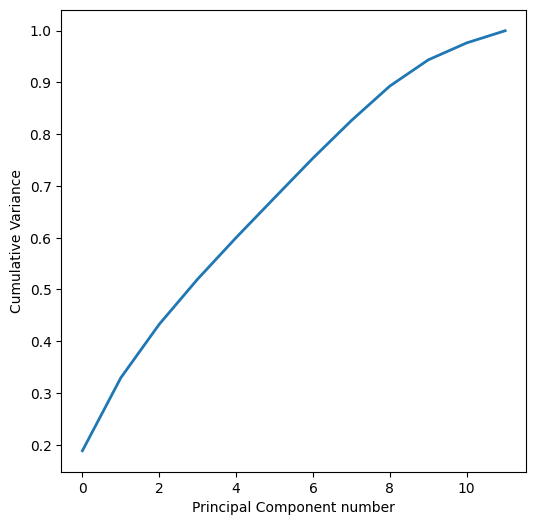

In [ ]:
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print(cum_evar)
plt.figure(1, figsize=(6, 6))
plt.xlabel("Principal Component number")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

Παρατηρούμε πως με 10 συνιστώσες περιγράφουμε το 99% της διακύμανσης του dataset.
Ο αριθμός των συνιστωσών που κρατάμε είναι μια από τις υπερπαραμέτρους που θα προσδιοριστεί μέσω του Cross Validation.

In [ ]:
n = 10
pca = PCA(n_components=n)

trainPCA = pca.fit_transform(train_reduced)
testPCA = pca.transform(test_reduced)

print(trainPCA.shape)

(92163, 10)


#### Multi Layer Perceptron (MLP)
Επίδοση τους ταξινομητή MLP στο πλέον ισορροπημένο dataset με κανονικοποιημένα δεδομένα.

In [ ]:
mlp = MLPClassifier()

print("MLP Before")
print(classification_report(test_labels,pred_mlp))

mlp.fit(train_scaled, train_labels)
mlp_pred_scaled = mlp.predict(test_scaled)
print("MLP After Normalization")
print(classification_report(test_labels,mlp_pred_scaled))

mlp.fit(trainPCA, train_labels)
mlp_pred_scaled = mlp.predict(testPCA)
print("MLP After Normalization, Varience Threshold and PCA")
print(classification_report(test_labels,mlp_pred_scaled))

MLP Before
              precision    recall  f1-score   support

           1       0.72      0.55      0.62      8187
           2       0.63      0.81      0.71     16981
           3       0.74      0.59      0.65     14331

    accuracy                           0.68     39499
   macro avg       0.70      0.65      0.66     39499
weighted avg       0.69      0.68      0.67     39499

MLP After Normalization
              precision    recall  f1-score   support

           1       0.72      0.57      0.64      8187
           2       0.67      0.79      0.72     16981
           3       0.73      0.66      0.69     14331

    accuracy                           0.70     39499
   macro avg       0.71      0.67      0.68     39499
weighted avg       0.70      0.70      0.69     39499

MLP After Normalization, Varience Threshold and PCA
              precision    recall  f1-score   support

           1       0.73      0.56      0.64      8187
           2       0.66      0.81      0.7

#### Support Vector Machines (SVM)
Επίδοση τους ταξινομητή SVM στο πλέον ισορροπημένο dataset με κανονικοποιημένα δεδομένα.

In [ ]:
svm = SVC()

print("SVM Before")
print(classification_report(test_labels,pred_svm))

svm.fit(train_scaled, train_labels)
svm_pred_scaled = svm.predict(test_scaled)
print("SVM After Normalization")
print(classification_report(test_labels,svm_pred_scaled))

svm.fit(trainPCA, train_labels)
svm_pred_scaled = svm.predict(testPCA)
print("SVM After Normalization, Varience Threshold and PCA")
print(classification_report(test_labels,svm_pred_scaled))

SVM Before
              precision    recall  f1-score   support

           1       0.77      0.45      0.57      8187
           2       0.60      0.80      0.68     16981
           3       0.70      0.59      0.64     14331

    accuracy                           0.65     39499
   macro avg       0.69      0.61      0.63     39499
weighted avg       0.67      0.65      0.65     39499

SVM After Normalization
              precision    recall  f1-score   support

           1       0.76      0.53      0.62      8187
           2       0.63      0.85      0.73     16981
           3       0.75      0.58      0.65     14331

    accuracy                           0.68     39499
   macro avg       0.71      0.65      0.67     39499
weighted avg       0.70      0.68      0.68     39499

SVM After Normalization, Varience Threshold and PCA
              precision    recall  f1-score   support

           1       0.74      0.53      0.62      8187
           2       0.63      0.86      0.7

#### Optuna

In [ ]:
!pip install optuna

In [ ]:
import optuna
import sklearn.datasets
from sklearn.datasets import fetch_openml
import sklearn.neural_network

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from optuna.visualization import plot_optimization_history

def objective(trial):

    c = trial.suggest_float('svc_c', 0.1, 10, log=True)
    svc = SVC(C=c, gamma='auto')

    pipe = Pipeline(steps=[('scaler', scaler), ('selector', selector), ('pca', pca), ('svc', svc)])
    vthreshold = [0, 0.1] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
    n_components = [10,11]
    estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    pca__n_components=n_components), 
                                    cv=2, 
                                    scoring='accuracy', 
                                    n_jobs=-1,
                                    verbose=1)
    estimator.fit(train, train_labels)
    pred = estimator.predict(test)
    print(estimator.best_params_)
    return accuracy_score(test_labels, pred)

study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=10) 
barplot = [0,0]
barplot[1]=(study.best_trial.value)  

[I 2021-12-03 12:21:23,191] A new study created in memory with name: no-name-fab28790-b805-41b9-80d1-cc7f4222c129


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  6.9min finished
[I 2021-12-03 12:35:41,046] Trial 0 finished with value: 0.6825236081926125 and parameters: {'svc_c': 0.7308494800851976}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 13.2min finished
[I 2021-12-03 13:06:42,558] Trial 1 finished with value: 0.6815109243271982 and parameters: {'svc_c': 6.3727939637377915}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  7.4min finished
[I 2021-12-03 13:20:41,342] Trial 2 finished with value: 0.6796880933694524 and parameters: {'svc_c': 0.11436998182711473}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 10.9min finished
[I 2021-12-03 13:45:23,508] Trial 3 finished with value: 0.6822451201296236 and parameters: {'svc_c': 4.1888591577281895}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  7.0min finished
[I 2021-12-03 13:59:02,446] Trial 4 finished with value: 0.68199194916327 and parameters: {'svc_c': 0.31815307247596986}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  7.0min finished
[I 2021-12-03 14:12:59,856] Trial 5 finished with value: 0.6821691688397175 and parameters: {'svc_c': 0.4705534970143907}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 10.2min finished
[I 2021-12-03 14:36:17,851] Trial 6 finished with value: 0.6821944859363528 and parameters: {'svc_c': 3.736367234652294}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  6.9min finished
[I 2021-12-03 14:49:51,559] Trial 7 finished with value: 0.6820172662599053 and parameters: {'svc_c': 0.32787947775010395}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 13.1min finished
[I 2021-12-03 15:21:13,878] Trial 8 finished with value: 0.6815868756171042 and parameters: {'svc_c': 6.6904276494106085}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  7.0min finished
[I 2021-12-03 15:34:48,341] Trial 9 finished with value: 0.6817894123901871 and parameters: {'svc_c': 0.2686905645673516}. Best is trial 0 with value: 0.6825236081926125.


{'pca__n_components': 11, 'selector__threshold': 0}


In [ ]:
plot_optimization_history(study)

Το παραπάνω διάγραμμα σε φωτογραφία σε περίπτωση που δεν εμφανίζεται.

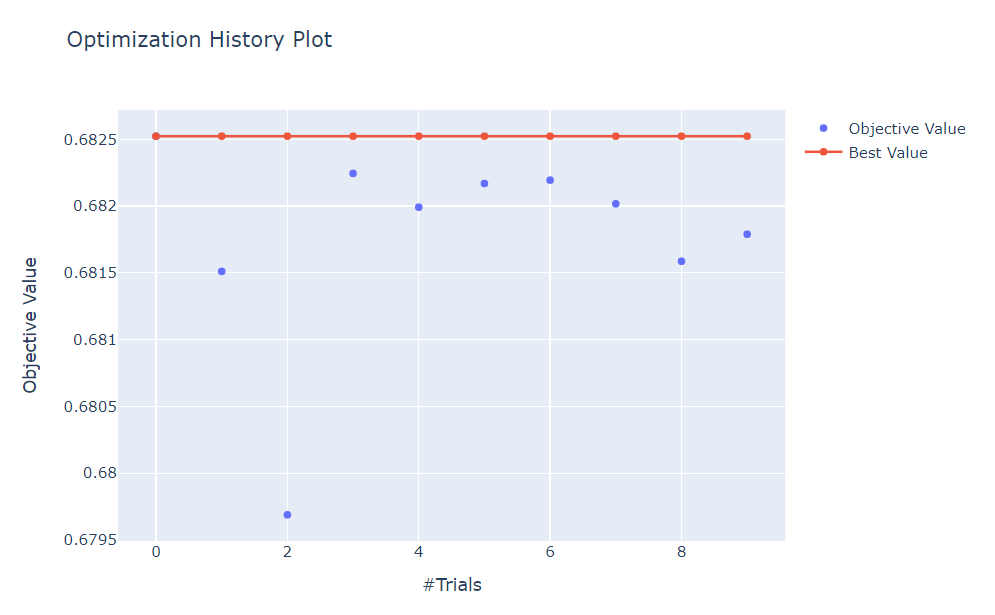

In [ ]:
def objective(trial):

    n_layers = trial.suggest_int('n_layers', 1, 100)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_{i}', 10, 20))
    mlp = MLPClassifier(hidden_layer_sizes=tuple(layers))
    

    pipe = Pipeline(steps=[('scaler', scaler), ('selector', selector), ('pca', pca), ('mlp', mlp)])
    vthreshold = [0, 0.1] #προσαρμόζουμε τις τιμές μας στο variance που παρατηρήσαμε
    n_components = [10,11]
    estimator = GridSearchCV(pipe, dict(selector__threshold=vthreshold, 
                                    pca__n_components=n_components), 
                                    cv=2, 
                                    scoring='accuracy', 
                                    n_jobs=-1,
                                    verbose=1)
    estimator.fit(train, train_labels)
    pred = estimator.predict(test)
    print(estimator.best_params_)
    return accuracy_score(test_labels, pred)

study = optuna.create_study(direction='maximize')  
study.optimize(objective, n_trials=20)  
barplot[0]=(study.best_trial.value)

[I 2021-12-03 15:34:48,531] A new study created in memory with name: no-name-8edf8524-64ff-4a69-80b9-b60f64185d0e


Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.1min finished
[I 2021-12-03 15:38:11,609] Trial 0 finished with value: 0.42990961796501176 and parameters: {'n_layers': 54, 'n_units_0': 18, 'n_units_1': 19, 'n_units_2': 16, 'n_units_3': 11, 'n_units_4': 14, 'n_units_5': 10, 'n_units_6': 10, 'n_units_7': 10, 'n_units_8': 17, 'n_units_9': 19, 'n_units_10': 11, 'n_units_11': 16, 'n_units_12': 16, 'n_units_13': 14, 'n_units_14': 20, 'n_units_15': 10, 'n_units_16': 18, 'n_units_17': 11, 'n_units_18': 16, 'n_units_19': 14, 'n_units_20': 18, 'n_units_21': 13, 'n_units_22': 17, 'n_units_23': 18, 'n_units_24': 17, 'n_units_25': 13, 'n_units_26': 19, 'n_units_27': 20, 'n_units_28': 13, 'n_units_29': 10, 'n_units_30': 16, 'n_units_31': 12, 'n_units_32': 19, 'n_units_33': 14, 'n_units_34': 15, 'n_units_35': 13, 'n_units_36': 12, 'n_units_37': 18, 'n_units_38': 13, 'n_units_39': 16, 'n_units_40': 15, 'n_units_41': 2

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.0min finished
[I 2021-12-03 15:44:02,686] Trial 1 finished with value: 0.42990961796501176 and parameters: {'n_layers': 88, 'n_units_0': 14, 'n_units_1': 20, 'n_units_2': 12, 'n_units_3': 11, 'n_units_4': 18, 'n_units_5': 16, 'n_units_6': 10, 'n_units_7': 13, 'n_units_8': 19, 'n_units_9': 14, 'n_units_10': 11, 'n_units_11': 16, 'n_units_12': 10, 'n_units_13': 10, 'n_units_14': 10, 'n_units_15': 20, 'n_units_16': 14, 'n_units_17': 12, 'n_units_18': 20, 'n_units_19': 18, 'n_units_20': 14, 'n_units_21': 16, 'n_units_22': 12, 'n_units_23': 12, 'n_units_24': 20, 'n_units_25': 17, 'n_units_26': 19, 'n_units_27': 10, 'n_units_28': 20, 'n_units_29': 15, 'n_units_30': 18, 'n_units_31': 12, 'n_units_32': 12, 'n_units_33': 10, 'n_units_34': 17, 'n_units_35': 20, 'n_units_36': 14, 'n_units_37': 20, 'n_units_38': 11, 'n_units_39': 18, 'n_units_40': 15, 'n_units_41': 1

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.3min finished
[I 2021-12-03 15:51:24,024] Trial 2 finished with value: 0.42990961796501176 and parameters: {'n_layers': 99, 'n_units_0': 19, 'n_units_1': 17, 'n_units_2': 20, 'n_units_3': 16, 'n_units_4': 13, 'n_units_5': 14, 'n_units_6': 16, 'n_units_7': 12, 'n_units_8': 11, 'n_units_9': 10, 'n_units_10': 20, 'n_units_11': 10, 'n_units_12': 11, 'n_units_13': 10, 'n_units_14': 11, 'n_units_15': 17, 'n_units_16': 12, 'n_units_17': 16, 'n_units_18': 13, 'n_units_19': 15, 'n_units_20': 16, 'n_units_21': 13, 'n_units_22': 12, 'n_units_23': 11, 'n_units_24': 20, 'n_units_25': 11, 'n_units_26': 11, 'n_units_27': 15, 'n_units_28': 16, 'n_units_29': 19, 'n_units_30': 16, 'n_units_31': 15, 'n_units_32': 10, 'n_units_33': 15, 'n_units_34': 10, 'n_units_35': 14, 'n_units_36': 10, 'n_units_37': 19, 'n_units_38': 10, 'n_units_39': 14, 'n_units_40': 15, 'n_units_41': 1

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.1min finished
[I 2021-12-03 15:54:24,499] Trial 3 finished with value: 0.42990961796501176 and parameters: {'n_layers': 45, 'n_units_0': 11, 'n_units_1': 14, 'n_units_2': 13, 'n_units_3': 16, 'n_units_4': 11, 'n_units_5': 18, 'n_units_6': 15, 'n_units_7': 17, 'n_units_8': 20, 'n_units_9': 12, 'n_units_10': 12, 'n_units_11': 10, 'n_units_12': 18, 'n_units_13': 12, 'n_units_14': 18, 'n_units_15': 14, 'n_units_16': 10, 'n_units_17': 14, 'n_units_18': 18, 'n_units_19': 19, 'n_units_20': 20, 'n_units_21': 16, 'n_units_22': 16, 'n_units_23': 17, 'n_units_24': 11, 'n_units_25': 13, 'n_units_26': 12, 'n_units_27': 20, 'n_units_28': 17, 'n_units_29': 20, 'n_units_30': 11, 'n_units_31': 11, 'n_units_32': 19, 'n_units_33': 19, 'n_units_34': 11, 'n_units_35': 12, 'n_units_36': 17, 'n_units_37': 10, 'n_units_38': 10, 'n_units_39': 17, 'n_units_40': 11, 'n_units_41': 1

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.2min finished
[I 2021-12-03 15:57:49,073] Trial 4 finished with value: 0.42990961796501176 and parameters: {'n_layers': 50, 'n_units_0': 14, 'n_units_1': 15, 'n_units_2': 18, 'n_units_3': 18, 'n_units_4': 20, 'n_units_5': 13, 'n_units_6': 20, 'n_units_7': 17, 'n_units_8': 12, 'n_units_9': 18, 'n_units_10': 12, 'n_units_11': 16, 'n_units_12': 11, 'n_units_13': 12, 'n_units_14': 17, 'n_units_15': 17, 'n_units_16': 16, 'n_units_17': 15, 'n_units_18': 12, 'n_units_19': 14, 'n_units_20': 10, 'n_units_21': 18, 'n_units_22': 11, 'n_units_23': 18, 'n_units_24': 11, 'n_units_25': 20, 'n_units_26': 12, 'n_units_27': 13, 'n_units_28': 10, 'n_units_29': 19, 'n_units_30': 16, 'n_units_31': 16, 'n_units_32': 10, 'n_units_33': 20, 'n_units_34': 11, 'n_units_35': 10, 'n_units_36': 17, 'n_units_37': 13, 'n_units_38': 17, 'n_units_39': 10, 'n_units_40': 16, 'n_units_41': 1

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  2.9min finished
[I 2021-12-03 16:02:08,687] Trial 5 finished with value: 0.42990961796501176 and parameters: {'n_layers': 70, 'n_units_0': 11, 'n_units_1': 10, 'n_units_2': 11, 'n_units_3': 15, 'n_units_4': 13, 'n_units_5': 19, 'n_units_6': 14, 'n_units_7': 10, 'n_units_8': 12, 'n_units_9': 11, 'n_units_10': 16, 'n_units_11': 19, 'n_units_12': 17, 'n_units_13': 18, 'n_units_14': 13, 'n_units_15': 19, 'n_units_16': 11, 'n_units_17': 15, 'n_units_18': 10, 'n_units_19': 19, 'n_units_20': 16, 'n_units_21': 10, 'n_units_22': 20, 'n_units_23': 20, 'n_units_24': 10, 'n_units_25': 12, 'n_units_26': 18, 'n_units_27': 11, 'n_units_28': 14, 'n_units_29': 17, 'n_units_30': 16, 'n_units_31': 10, 'n_units_32': 18, 'n_units_33': 14, 'n_units_34': 19, 'n_units_35': 11, 'n_units_36': 14, 'n_units_37': 18, 'n_units_38': 14, 'n_units_39': 18, 'n_units_40': 18, 'n_units_41': 1

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.5min finished
[I 2021-12-03 16:08:25,261] Trial 6 finished with value: 0.693384642649181 and parameters: {'n_layers': 7, 'n_units_0': 20, 'n_units_1': 13, 'n_units_2': 18, 'n_units_3': 10, 'n_units_4': 18, 'n_units_5': 10, 'n_units_6': 14}. Best is trial 6 with value: 0.693384642649181.


{'pca__n_components': 10, 'selector__threshold': 0.1}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 12.2min finished
[I 2021-12-03 16:21:12,875] Trial 7 finished with value: 0.42990961796501176 and parameters: {'n_layers': 26, 'n_units_0': 13, 'n_units_1': 15, 'n_units_2': 17, 'n_units_3': 13, 'n_units_4': 20, 'n_units_5': 10, 'n_units_6': 12, 'n_units_7': 12, 'n_units_8': 17, 'n_units_9': 17, 'n_units_10': 11, 'n_units_11': 16, 'n_units_12': 12, 'n_units_13': 14, 'n_units_14': 15, 'n_units_15': 10, 'n_units_16': 11, 'n_units_17': 14, 'n_units_18': 18, 'n_units_19': 10, 'n_units_20': 20, 'n_units_21': 13, 'n_units_22': 17, 'n_units_23': 19, 'n_units_24': 17, 'n_units_25': 11}. Best is trial 6 with value: 0.693384642649181.


{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  3.7min finished
[I 2021-12-03 16:26:40,336] Trial 8 finished with value: 0.42990961796501176 and parameters: {'n_layers': 83, 'n_units_0': 14, 'n_units_1': 20, 'n_units_2': 12, 'n_units_3': 12, 'n_units_4': 19, 'n_units_5': 11, 'n_units_6': 10, 'n_units_7': 18, 'n_units_8': 15, 'n_units_9': 13, 'n_units_10': 15, 'n_units_11': 14, 'n_units_12': 17, 'n_units_13': 17, 'n_units_14': 12, 'n_units_15': 12, 'n_units_16': 19, 'n_units_17': 11, 'n_units_18': 10, 'n_units_19': 14, 'n_units_20': 11, 'n_units_21': 17, 'n_units_22': 10, 'n_units_23': 16, 'n_units_24': 10, 'n_units_25': 11, 'n_units_26': 20, 'n_units_27': 19, 'n_units_28': 15, 'n_units_29': 11, 'n_units_30': 14, 'n_units_31': 20, 'n_units_32': 18, 'n_units_33': 17, 'n_units_34': 12, 'n_units_35': 13, 'n_units_36': 15, 'n_units_37': 15, 'n_units_38': 11, 'n_units_39': 10, 'n_units_40': 17, 'n_units_41': 1

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.8min finished
[I 2021-12-03 16:33:11,923] Trial 9 finished with value: 0.42990961796501176 and parameters: {'n_layers': 84, 'n_units_0': 15, 'n_units_1': 10, 'n_units_2': 13, 'n_units_3': 19, 'n_units_4': 13, 'n_units_5': 15, 'n_units_6': 18, 'n_units_7': 14, 'n_units_8': 17, 'n_units_9': 17, 'n_units_10': 10, 'n_units_11': 20, 'n_units_12': 16, 'n_units_13': 13, 'n_units_14': 10, 'n_units_15': 10, 'n_units_16': 15, 'n_units_17': 11, 'n_units_18': 15, 'n_units_19': 20, 'n_units_20': 17, 'n_units_21': 12, 'n_units_22': 15, 'n_units_23': 11, 'n_units_24': 19, 'n_units_25': 11, 'n_units_26': 19, 'n_units_27': 16, 'n_units_28': 18, 'n_units_29': 11, 'n_units_30': 18, 'n_units_31': 13, 'n_units_32': 18, 'n_units_33': 11, 'n_units_34': 13, 'n_units_35': 18, 'n_units_36': 18, 'n_units_37': 10, 'n_units_38': 13, 'n_units_39': 16, 'n_units_40': 13, 'n_units_41': 1

{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.7min finished
[I 2021-12-03 16:35:35,826] Trial 10 finished with value: 0.6946251803843135 and parameters: {'n_layers': 2, 'n_units_0': 17, 'n_units_1': 12}. Best is trial 10 with value: 0.6946251803843135.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.2min finished
[I 2021-12-03 16:37:18,575] Trial 11 finished with value: 0.6798399959492646 and parameters: {'n_layers': 1, 'n_units_0': 17}. Best is trial 10 with value: 0.6946251803843135.


{'pca__n_components': 11, 'selector__threshold': 0.1}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.7min finished
[I 2021-12-03 16:39:42,148] Trial 12 finished with value: 0.6956378642497278 and parameters: {'n_layers': 2, 'n_units_0': 20, 'n_units_1': 12}. Best is trial 12 with value: 0.6956378642497278.


{'pca__n_components': 11, 'selector__threshold': 0.1}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 10.9min finished
[I 2021-12-03 16:54:42,195] Trial 13 finished with value: 0.6953593761867389 and parameters: {'n_layers': 18, 'n_units_0': 18, 'n_units_1': 12, 'n_units_2': 10, 'n_units_3': 14, 'n_units_4': 10, 'n_units_5': 20, 'n_units_6': 20, 'n_units_7': 20, 'n_units_8': 14, 'n_units_9': 20, 'n_units_10': 20, 'n_units_11': 13, 'n_units_12': 20, 'n_units_13': 20, 'n_units_14': 14, 'n_units_15': 14, 'n_units_16': 20, 'n_units_17': 20}. Best is trial 12 with value: 0.6956378642497278.


{'pca__n_components': 11, 'selector__threshold': 0.1}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 17.5min finished
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[I 2021-12-03 17:23:49,532] Trial 14 finished with value: 0.6832071698017671 and parameters: {'n_layers': 23, 'n_units_0': 20, 'n_units_1': 12, 'n_units_2': 10, 'n_units_3': 14, 'n_units_4': 10, 'n_units_5': 20, 'n_units_6': 20, 'n_units_7': 20, 'n_units_8': 14, 'n_units_9': 20, 'n_units_10': 20, 'n_units_11': 13, 'n_units_12': 19, 'n_units_13': 20, '

{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 14.1min finished
[I 2021-12-03 17:45:09,701] Trial 15 finished with value: 0.6953846932833743 and parameters: {'n_layers': 20, 'n_units_0': 17, 'n_units_1': 12, 'n_units_2': 14, 'n_units_3': 20, 'n_units_4': 16, 'n_units_5': 17, 'n_units_6': 18, 'n_units_7': 20, 'n_units_8': 10, 'n_units_9': 16, 'n_units_10': 18, 'n_units_11': 12, 'n_units_12': 20, 'n_units_13': 20, 'n_units_14': 17, 'n_units_15': 16, 'n_units_16': 17, 'n_units_17': 20, 'n_units_18': 14, 'n_units_19': 12}. Best is trial 12 with value: 0.6956378642497278.


{'pca__n_components': 11, 'selector__threshold': 0.1}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.5min finished
[I 2021-12-03 18:07:34,254] Trial 16 finished with value: 0.6872072710701537 and parameters: {'n_layers': 35, 'n_units_0': 16, 'n_units_1': 17, 'n_units_2': 15, 'n_units_3': 20, 'n_units_4': 17, 'n_units_5': 17, 'n_units_6': 17, 'n_units_7': 16, 'n_units_8': 11, 'n_units_9': 15, 'n_units_10': 18, 'n_units_11': 11, 'n_units_12': 14, 'n_units_13': 17, 'n_units_14': 17, 'n_units_15': 17, 'n_units_16': 17, 'n_units_17': 18, 'n_units_18': 14, 'n_units_19': 12, 'n_units_20': 12, 'n_units_21': 20, 'n_units_22': 14, 'n_units_23': 14, 'n_units_24': 14, 'n_units_25': 17, 'n_units_26': 15, 'n_units_27': 17, 'n_units_28': 10, 'n_units_29': 14, 'n_units_30': 10, 'n_units_31': 20, 'n_units_32': 15, 'n_units_33': 17, 'n_units_34': 20}. Best is trial 12 with value: 0.6956378642497278.


{'pca__n_components': 10, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  8.2min finished
[I 2021-12-03 18:19:21,274] Trial 17 finished with value: 0.6963973771487886 and parameters: {'n_layers': 11, 'n_units_0': 19, 'n_units_1': 11, 'n_units_2': 14, 'n_units_3': 18, 'n_units_4': 16, 'n_units_5': 13, 'n_units_6': 18, 'n_units_7': 19, 'n_units_8': 10, 'n_units_9': 16, 'n_units_10': 15}. Best is trial 17 with value: 0.6963973771487886.


{'pca__n_components': 11, 'selector__threshold': 0}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  7.6min finished
/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
[I 2021-12-03 18:35:19,696] Trial 18 finished with value: 0.696574596825236 and parameters: {'n_layers': 12, 'n_units_0': 19, 'n_units_1': 10, 'n_units_2': 20, 'n_units_3': 17, 'n_units_4': 15, 'n_units_5': 12, 'n_units_6': 18, 'n_units_7': 18, 'n_units_8': 13, 'n_units_9': 14, 'n_units_10': 14, 'n_units_11': 18}. Best is trial 18 with value: 0.696574596825236.


{'pca__n_components': 11, 'selector__threshold': 0.1}
Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.9min finished
[I 2021-12-03 18:38:01,891] Trial 19 finished with value: 0.42990961796501176 and parameters: {'n_layers': 37, 'n_units_0': 19, 'n_units_1': 10, 'n_units_2': 20, 'n_units_3': 17, 'n_units_4': 15, 'n_units_5': 12, 'n_units_6': 18, 'n_units_7': 18, 'n_units_8': 13, 'n_units_9': 15, 'n_units_10': 14, 'n_units_11': 18, 'n_units_12': 14, 'n_units_13': 16, 'n_units_14': 20, 'n_units_15': 12, 'n_units_16': 13, 'n_units_17': 17, 'n_units_18': 17, 'n_units_19': 17, 'n_units_20': 14, 'n_units_21': 10, 'n_units_22': 13, 'n_units_23': 14, 'n_units_24': 14, 'n_units_25': 20, 'n_units_26': 15, 'n_units_27': 13, 'n_units_28': 12, 'n_units_29': 13, 'n_units_30': 20, 'n_units_31': 17, 'n_units_32': 15, 'n_units_33': 12, 'n_units_34': 15, 'n_units_35': 16, 'n_units_36': 20}. Best is trial 18 with value: 0.696574596825236.


{'pca__n_components': 10, 'selector__threshold': 0}


In [ ]:
plot_optimization_history(study)

Το παραπάνω διάγραμμα σε φωτογραφία σε περίπτωση που δεν εμφανίζεται.

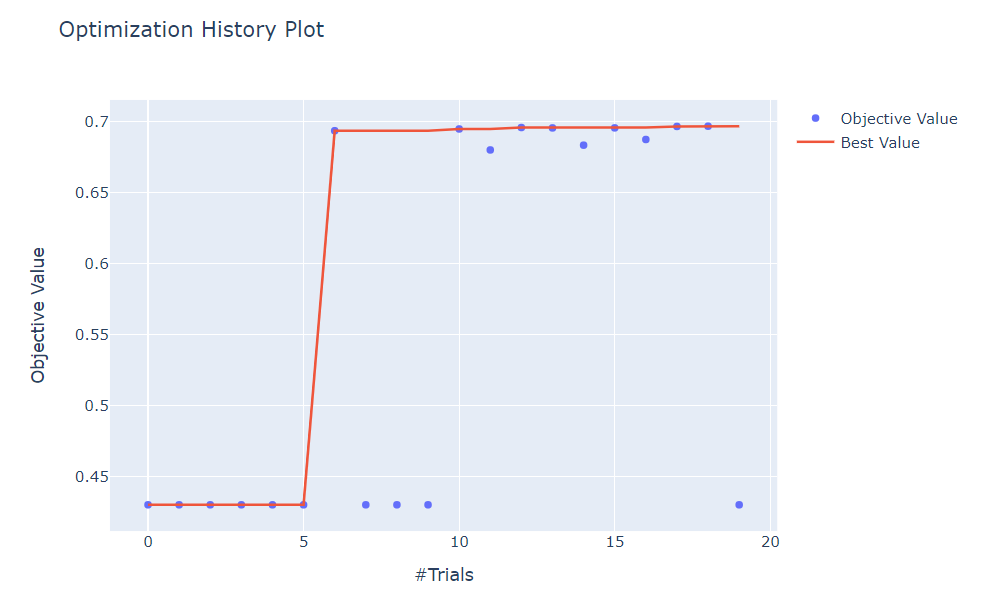

In [ ]:
print("MLP with no optimazations:", barplotbefore[0])
print("MLP with optimazations:", barplot[0])
print("SVM with no optimazations:", barplotbefore[1])
print("SVM with optimazations:", barplot[1])

MLP with no optimazations: 0.6771057495126459
MLP with optimazations: 0.696574596825236
SVM with no optimazations: 0.6522949948099952
SVM with optimazations: 0.6825236081926125


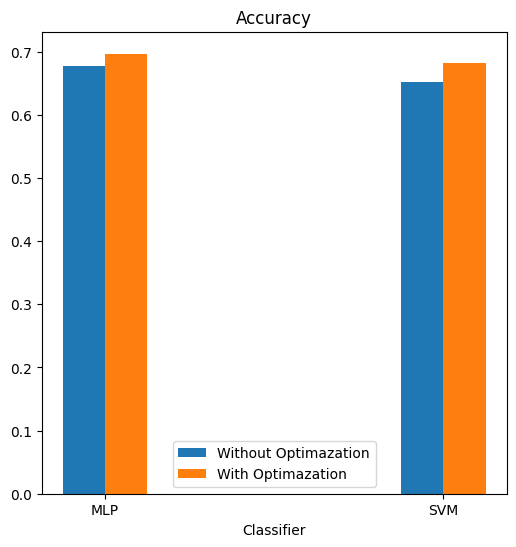

In [ ]:
classifiers = ['MLP', 'SVM']

plt.figure(figsize=(6,6)) 
X_axis = np.arange(len(classifiers))

plt.bar(X_axis - 0.0625, barplotbefore, 0.125, label = 'Without Optimazation')
plt.bar(X_axis + 0.0625, barplot, 0.125, label = 'With Optimazation')
  
plt.xticks(X_axis, classifiers)
plt.xlabel("Classifier")
plt.title("Accuracy")
plt.legend()
plt.show()

### Τεκμηρίωση της διαδικασίας
Γενικά, κατά τη διαδικασία βελτιστοποίησης των δύο ταξινομητών, έχουμε κάνει αρκετή προεπεξεργασία στα δεδομένα μας. Αρχικά, επειδή αντιμετωπίζαμε ένα μη ισοζυγισμένο dataset, εφαρμόσαμε undersampling (όχι oversampling, λόγω μεγάλου όγκου δεδομένων και για λόγους ταχύτητας) για να ισορροπήσουμε το dataset. Επιπλέον, θέλαμε να διώξουμε χαρακτηριστικά με πολύ μικρή διακύμανση που δεν θα προσέφεραν στην απόφαση του ταξινομητή και με κανονικοποίηση προσπαθούμε να αμβλύνουμε κάποιες πολύ μεγάλες διαφορές στις τιμές των χαρακτηριστικών μας. Στη συνέχεια, θέλουμε να υπολογίσουμε, με τη βοήθεια της βιβλιοθήκης βελτιστοποίησης Optuna, τις βέλτιστες τιμές για τις υπερπαραμέτρους κάθε ταξινομητή, καθώς και του Variance Threshlod και του PCA, μέσω της χρήσης pipeline (πρώτα κανονικοποιήση μετά Variance Threshold και μετά PCA). Τέλος, παρουσιάζουμε τα αποτελέσματα συγκριτικά με την Out-of-the-box επίδοση τους σε ένα markdown table και σε ένα bar διάγραμμα.

### Παρουσίαση αποτελεσμάτων και συμπεράσματα
Μετά από αρκετές δοκιμές και διάφορους συνδυασμούς μετασχηματιστών στα pipelines, καταλήξαμε στα παραπάνω αποτελέσματα, τα οποία ήταν τα καλύτερα που μπορέσαμε να εξάγουμε, εντός των 9 ωρών που τρέχει το Kaggle. Η βελτίωση που παρατηρείται και για τους δύο ταξινομητές είναι αρκετά μικρή, αλλά κάνοντας μία μικρή έρευνα για το state-of-the-art του dataset μας, είδαμε πως η καλύτερη επίδοση που έχει παρουσιαστεί είναι περίπου 69% και άρα πολύ κοντά στα δικά μας αποτελέσματα. 

Τελικά, οι δύο ταξινομητές έχουν παρόμοια απόδοση, αλλά μάλλον θα επιλέγαμε τον MLP Classifier καθώς είναι αρκετά πιο γρήγορος από τον SVM. Επιπλέον, ο SVM απαιτεί προσαρμογή για multiclass classification, επομένως δεν είναι ο ιδανικός ταξινομητής για το dataset μας. Στην διαδικασία Pipeline και optuna βγαίνει convergence warning αλλά έχοντας κάνει πολλές δοκιμές βλέπουμε ότι αυτο δεν έχει αντίκτυπο στο τελικό αποτέλεσμα.